In [1]:
import os, shutil, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras

In [2]:
train_dir = os.path.join("C:/Users/ASUS/OneDrive/Desktop/Smart Bin/Trash Images",'train')
test_dir = os.path.join("C:/Users/ASUS/OneDrive/Desktop/Smart Bin/Trash Images",'test')
origin_dir = os.path.join("C:/Users/ASUS/OneDrive/Desktop/Smart Bin/Trash Images/garbage_classification")
categories = os.listdir(origin_dir)


In [3]:
for category in categories:
    category_src_path = os.path.join(origin_dir, category)
    category_dst_path_train = os.path.join(train_dir, category)
    category_dst_path_test = os.path.join(test_dir, category)
    os.makedirs(category_dst_path_train, exist_ok = True)
    os.makedirs(category_dst_path_test, exist_ok = True)
    
    file_names = os.listdir(category_src_path)
    random.shuffle(file_names)
    length = len(file_names)
    train_file_names = file_names[:int(length*0.8)]
    test_file_names = file_names[int(length*0.8):]
    
    for name in train_file_names:
        src_path = os.path.join(category_src_path, name)
        dst_path = os.path.join(category_dst_path_train, name)
        shutil.copyfile(src = src_path,
                        dst = dst_path)
        
    for name in test_file_names:
        src_path = os.path.join(category_src_path, name)
        dst_path = os.path.join(category_dst_path_test, name)
        shutil.copyfile(src = src_path,
                        dst = dst_path)


In [4]:
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,
                                                             validation_split = 0.2)
test_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)

train_data = train_gen.flow_from_directory(r"C:\Users\ASUS\OneDrive\Desktop\Smart Bin\Trash Images\train",
                                            subset = "training", seed = 42, target_size = (299, 299))
val_data = train_gen.flow_from_directory(r"C:\Users\ASUS\OneDrive\Desktop\Smart Bin\Trash Images\train",
                                            subset = "validation", seed = 42, target_size = (299, 299))
test_data = test_gen.flow_from_directory(r"C:\Users\ASUS\OneDrive\Desktop\Smart Bin\Trash Images\test", seed = 42, target_size = (299, 299))

Found 12416 images belonging to 12 classes.
Found 3100 images belonging to 12 classes.
Found 14457 images belonging to 12 classes.


In [5]:
class_counts = {}

train_path = os.path.join(r"C:\Users\ASUS\OneDrive\Desktop\Smart Bin\Trash Images\train")
for cls in os.listdir(train_path):
    class_path = os.path.join(train_path, cls)
    class_counts[cls] = len(os.listdir(class_path))
    
class_counts = dict(sorted(class_counts.items(), key=lambda x:x[1], reverse = True))
class_counts

{'clothes': 5326,
 'shoes': 1977,
 'paper': 1050,
 'biological': 985,
 'battery': 945,
 'cardboard': 891,
 'plastic': 865,
 'white-glass': 775,
 'metal': 769,
 'trash': 697,
 'green-glass': 629,
 'brown-glass': 607}

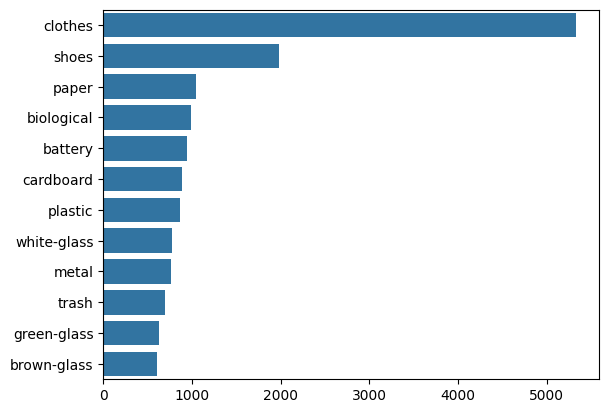

In [6]:
g = sns.barplot(x = list(class_counts.values()), y = list(class_counts.keys()))

In [7]:
class_names = list(train_data.class_indices.keys())
class_names

['battery',
 'biological',
 'brown-glass',
 'cardboard',
 'clothes',
 'green-glass',
 'metal',
 'paper',
 'plastic',
 'shoes',
 'trash',
 'white-glass']

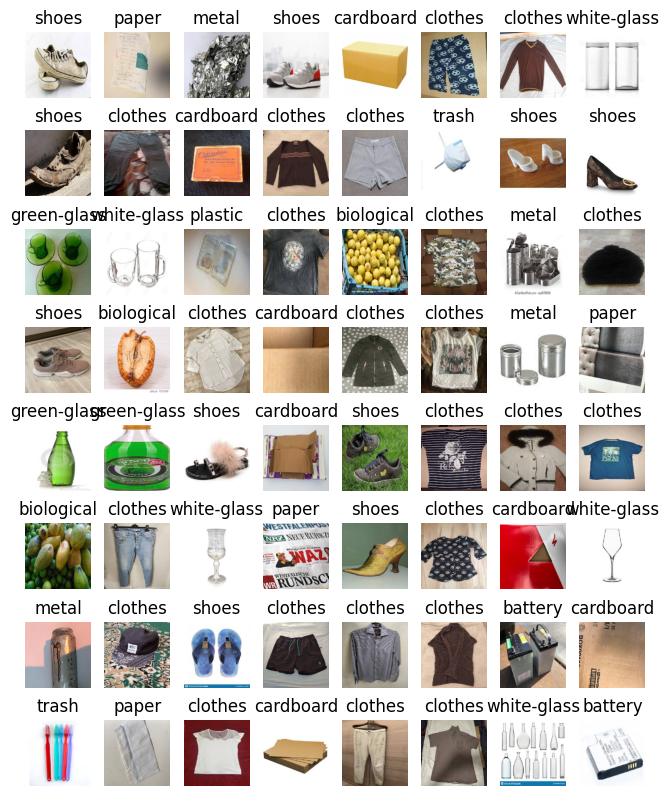

In [8]:
fig, ax = plt.subplots(8, 8, figsize = (8, 10))
for i in range(8*8):
    img = train_data[i][0][0]
    current_axis = ax[i // 8][i % 8]
    class_idx = np.argmax(train_data[i][1][0])
    current_axis.set_title(class_names[class_idx])
    current_axis.imshow(img)
    current_axis.axis("off")

In [9]:
base_model = tf.keras.applications.xception.Xception(include_top = False,
                                                 weights = "imagenet",
                                                 input_shape = (299, 299, 3))
data_augmentation = keras.Sequential(
    [
        keras.layers.RandomFlip("horizontal"),
        keras.layers.RandomRotation(0.1),
        keras.layers.RandomZoom(0.2),
    ]
)
x = data_augmentation(base_model.output)
avg = keras.layers.GlobalAveragePooling2D()(x)
output = keras.layers.Dense(12, activation = "softmax")(avg)
model = keras.Model(inputs = base_model.input, outputs = output)

In [10]:
for layer in base_model.layers:
    layer.trainable = False

In [11]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
    filepath="top_aug_no_sh.keras",
    save_best_only=True,
    monitor="val_loss"),
    
    keras.callbacks.EarlyStopping(patience = 10,
                                  restore_best_weights = True)
]

In [12]:
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [13]:
optimizer = keras.optimizers.SGD(learning_rate = 0.2, momentum = 0.9)
model.compile(loss = "categorical_crossentropy", optimizer = optimizer,
              metrics = ["accuracy"])
history = model.fit(train_data,
                    epochs = 2,
                    validation_data = val_data,
                    callbacks = callbacks
                   )

Epoch 1/2


c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 18/388 ━━━━━━━━━━━━━━━━━━━━ 11:30 2s/step - accuracy: 0.4988 - loss: 1.6893

KeyboardInterrupt: 

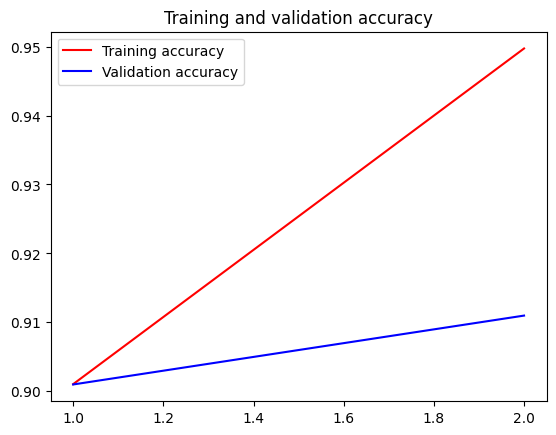

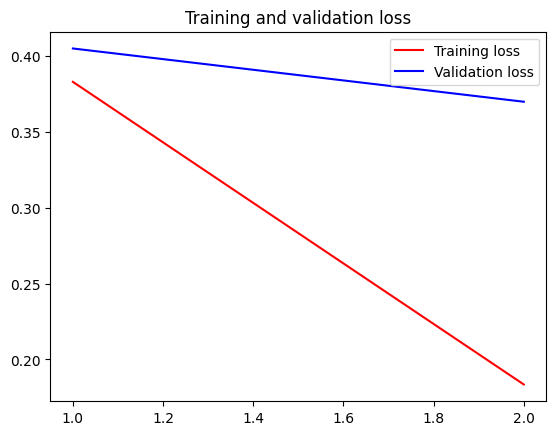

In [18]:
accuracy  = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "r", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "r", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [19]:
for layer in base_model.layers:
    layer.trainable = True

    
callbacks = [
    keras.callbacks.ModelCheckpoint(
    filepath="model_aug_no_sh.keras",
    save_best_only=True,
    monitor="val_loss"),
    
    keras.callbacks.EarlyStopping(patience = 10,
                                  restore_best_weights = True)
]

In [48]:
optimizer = keras.optimizers.SGD(learning_rate = 0.01, momentum = 0.9)
model.compile(loss = "categorical_crossentropy", optimizer = optimizer,
              metrics = ["accuracy"])
history = model.fit(train_data,
                    epochs = 2,
                    validation_data = val_data,
                    callbacks = callbacks
                    
                    
                    
                   )

Epoch 1/2
 76/388 ━━━━━━━━━━━━━━━━━━━━ 1:27:55 17s/step - accuracy: 0.9265 - loss: 0.2911

KeyboardInterrupt: 

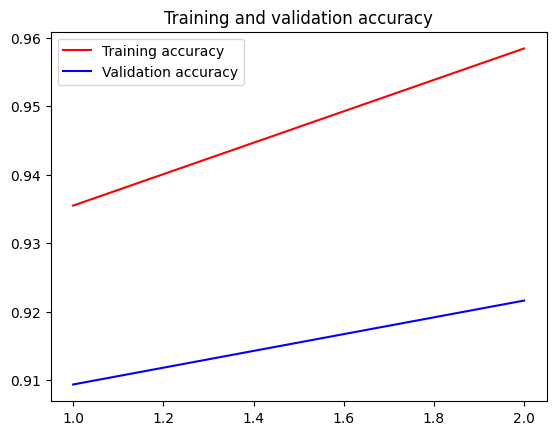

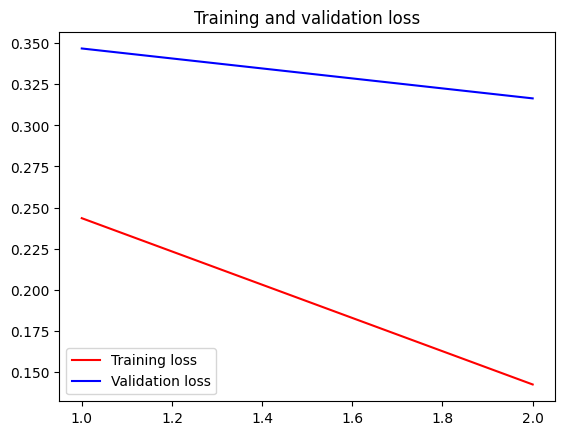

In [49]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "r", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "r", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [50]:
def get_prediction(img_path):

    class_names = list(train_data.class_indices.keys())
    img = plt.imread(img_path)
    plt.imshow(img)
    plt.axis("off")
    img = tf.image.resize(img, (299, 299))
    img *= 1./255
    img = np.expand_dims(img, axis = 0)
    predictions = model.predict(img)
    plt.title(class_names[np.argmax(predictions)])

In [ ]:
# import cv2
# import numpy as np
# from matplotlib import pyplot as plt
# import tensorflow as tf


In [ ]:
# # Assuming `model` and `train_data` are already defined
# class_names = list(train_data.class_indices.keys())

# def get_prediction(img):
#     plt.imshow(img)
#     plt.axis("off")
    
#     img = tf.image.resize(img, (299, 299))
#     img *= 1./255
#     img = np.expand_dims(img, axis=0)
    
#     predictions = model.predict(img)
#     plt.title(class_names[np.argmax(predictions)])
#     s = class_names[np.argmax(predictions)]
#     plt.show()
#     return s


In [ ]:
# cap = cv2.VideoCapture(0)

In [ ]:
# # Open the camera (0 is typically the default camera)
# cap = cv2.VideoCapture(0)

# while True:
#     ret, frame = cap.read()

#     if not ret:
#         print("Failed to capture image from camera.")
#         break

#     # Convert BGR image to RGB
#     img_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

#     # Display the prediction
#     s = get_prediction(img_rgb)

#     # Break the loop if the 'q' key is pressed
#     if cv2.waitKey(1) & 0xFF == ord('q'):
#         break




Failed to capture image from camera.


In [ ]:
# #  close the OpenCV window
# cap.release()
# cv2.destroyAllWindows()

error: OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\highgui\src\window.cpp:1266: error: (-2:Unspecified error) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Cocoa support. If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in function 'cvDestroyAllWindows'
